<a href="https://colab.research.google.com/github/LuluW8071/Data-Science/blob/main/Pytorch/09_PyTorch_GANs/02_PyTorch_DCGANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Convolutional Generative Adversarial Networks (DCGANs)

<img src = "https://miro.medium.com/v2/resize:fit:1400/0*DJGVvDYO6-u-WYhk.gif">

**Deep Convolutional Generative Adversarial Networks (DCGANs)** are a specific type of GAN that leverage deep convolutional neural networks to generate realistic data samples, especially images. DCGANs follow the same adversarial learning framework as standard GANs but incorporate convolutional layers to improve the quality and stability of the generated outputs. They consist of two neural networks:
- generator
- discriminator

The **generator** in a DCGAN uses transposed convolutional layers (also known as deconvolutional layers) to transform random noise into realistic images. The generator is designed to capture spatial hierarchies and details in the images it creates.

The **discriminator** in a DCGAN uses convolutional layers to evaluate the authenticity of the images, distinguishing between real images from the training dataset and fake images produced by the generator. The discriminator employs techniques like strided convolutions and LeakyReLU activations to effectively analyze and classify the input images.

The two networks are trained simultaneously in a competitive process: the generator improves its ability to produce realistic images, and the discriminator enhances its skill in detecting fake images. This adversarial training process leads to the generator producing highly realistic images, making DCGANs powerful tools for tasks like image synthesis, video generation, and data augmentation. By incorporating convolutional architectures, DCGANs can generate higher-quality images compared to traditional GANs, effectively capturing the complexities of visual data.

### [Paper on DCGANs](https://arxiv.org/pdf/1511.06434)
## DCGAN Architecture & Working Mechanism

<img src="https://miro.medium.com/v2/resize:fit:800/0*_PEWcPKaXEBla9pP.png">

1. **Input Noise:** The process starts with the generator receiving random noise from the latent space.

2. **Data Generation:** The generator transforms this noise into a new data sample, trying to mimic the real data distribution.

3. **Discrimination:** The generated data sample is then fed into the discriminator alongside real samples from the training set.

4. **Classification:** The discriminator evaluates the data and determines whether each sample is real or fake.

5. **Feedback Loop:** If the discriminator correctly identifies the fake sample, it means the generator needs improvement. The generator is trained to produce more realistic data to fool the discriminator in the next round. Conversely, if the discriminator is fooled by the fake data, it needs further training to improve its accuracy.

6. **Adversarial Training:** The generator and discriminator are trained simultaneously in a zero-sum game. The generator's objective is to maximize the discriminator's error rate, effectively generating more realistic data. The discriminator's objective is to minimize its error rate, improving its ability to distinguish between real and fake samples.

The main difference between **standard GANs** and **DCGANs** lies in the use of convolutional layers in both the generator and the discriminator, which are designed to handle image data more effectively. This adversarial process continues until the generator produces sufficiently realistic data that the discriminator can no longer distinguish it from real data with high accuracy.




## 0. Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

# Setting up device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 1. Data Preparation

Using MNIST dataset (handwritten-digits) images for data and training GAN on it to classify the real and fake samples not labels.

In [2]:
# Transform the PIL Image array
transform = transforms.Compose([
      transforms.Resize(64),
      transforms.ToTensor(),
      transforms.Normalize((0.5,),(0.5,)),    # Normalizes on range -1 to 1 [output = (input - mean) / std]
])

# Setting up training data
train_data = datasets.MNIST(root="data",            # Storage location of dataset
                            train=True,             # Indication of downloading train_datasets
                            download=True,          # Flag to set for downloading datasets
                            transform=transform,    # Transformation of image dataset
                            target_transform=None)  # Flag to set for transformation of labels/targets

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16410838.76it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 531548.69it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 3954285.66it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9037252.74it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## 2. Visualization of MNIST Data Samples

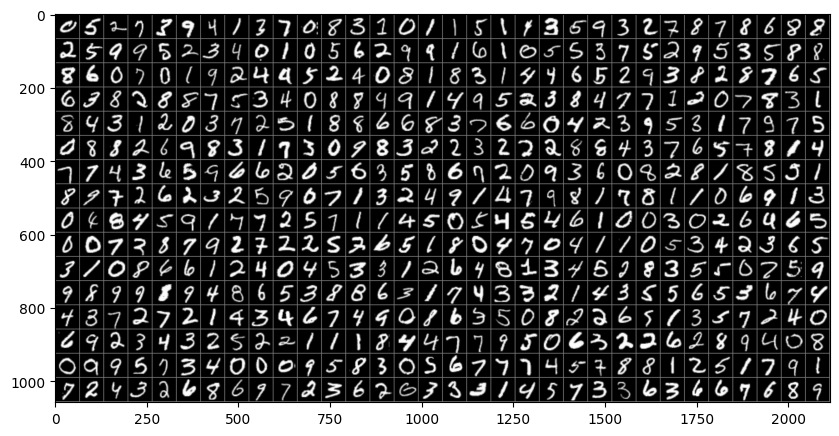

Shape of a batch of images: torch.Size([512, 1, 64, 64])


In [26]:
def visualize(img):
    img = img/2 + 0.5       # Denormalize
    img_np = img.numpy()    # Transform to numpy array
    plt.imshow(np.transpose(img_np, (1, 2, 0)), cmap='gray')
    plt.show()

def show_grid(images, n_row=32):
    img_grid = torchvision.utils.make_grid(images, nrow=n_row)
    visualize(img_grid)

# Get some random training images
trainloader = torch.utils.data.DataLoader(train_data, batch_size=512, num_workers=2, shuffle=True)
data_iter = iter(trainloader)
images, labels = next(data_iter)

# Display the images in a grid
plt.figure(figsize=(10, 10))
show_grid(images)

print(f"Shape of a batch of images: {images.shape}")

In [4]:
def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, ((nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d))):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

## 3. Building DCGAN Neural Network
### 3.1 Building Discriminator

Discriminator is a classifier that takes image as input and distinguishes between Real or Fake as output.

>For DCGANs, Convolution layers are used.

<img src = "https://learnopencv.com/wp-content/uploads/2021/07/dcgan-discriminator.jpg">

In [5]:
class Discriminator(nn.Module):
    def __init__(self, input_channels, hidden_size, output_size):
        super(Discriminator, self).__init__()
        self.classifier = nn.Sequential(
            # Input = N x channels_img x 64 x 64
            # First convolutional layer: 32 x 32
            nn.Conv2d(input_channels, hidden_size, kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2),

            # Second convolutional layer: 16 x 16
            self._conv_block(hidden_size, hidden_size * 2, 4, 2, 1),

            # Third convolutional layer: 8 x 8
            self._conv_block(hidden_size * 2, hidden_size * 4, 4, 2, 1),

            # Fourth convolutional layer: 4 x 4
            self._conv_block(hidden_size * 4, hidden_size * 8, 4, 2, 1),

            # Final convolutional layer: 1 x 1
            nn.Conv2d(hidden_size * 8, output_size, kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()  # Sigmoid activation is used in the discriminator to output a probability
        )


    def _conv_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels,
                      out_channels,
                      kernel_size,
                      stride,
                      padding,
                      bias=False),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )


    def forward(self, x):
        return self.classifier(x)

In [6]:
discriminator = Discriminator(input_channels = 1,           # Color channel for grayscale = 1
                              hidden_size = 64,
                              output_size = 1).to(device)   # Binary Classification
discriminator.apply(initialize_weights)
discriminator

Discriminator(
  (classifier): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Sequential(
      (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (3): Sequential(
      (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (4): Sequential(
      (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.2)
    )
    (5): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (6): 

### 3.2 Building Generator Network

Generator is a model that generates a fake image from a vector also called latent vector or noise vector.

> For DCGANs, Convolution layers are used and `latent vector of dimension 200` shall be used.

> NOTE:
- Latent vector dimension must be between image shape(width*height).
- It also must not be set too high or too low.
- It is generally beneficial to use architectures with a similar number of layers for both the generator and discriminator because maintaining a balance in their complexity can prevent one network from overpowering the other, thus ensuring more stable and effective training.

<img src = "https://miro.medium.com/v2/resize:fit:1200/1*5ALjnfAqwcWbOsledTBXsw.png">

In [7]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Generator, self).__init__()
        self.generator = nn.Sequential(
            # Input = N x latent_dim x 1 x 1
            # First transposed convolutional layer: N x features*8 x 4 x 4
            self._transpose_conv_block(input_size, hidden_size * 8, 4, 1, 0),

            # Second transposed convolutional layer: 8 x 8
            self._transpose_conv_block(hidden_size * 8, hidden_size * 4, 4, 2, 1),

            # Third transposed convolutional layer: 16 x 16
            self._transpose_conv_block(hidden_size * 4, hidden_size * 2, 4, 2, 1),

            # Fourth transposed convolutional layer: 32 x 32
            self._transpose_conv_block(hidden_size * 2, hidden_size, 4, 2, 1),

            # Final transposed convolutional layer: 64 x 64
            nn.ConvTranspose2d(hidden_size, output_size, kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh()  # Tanh activation is used to output values in the range [-1, 1]
        )


    def _transpose_conv_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels,
                               out_channels,
                               kernel_size,
                               stride,
                               padding,
                               bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )


    def forward(self, x):
        return self.generator(x)

In [8]:
latent_dim = 100
generator = Generator(input_size = latent_dim,          # latent vector or noise vector dimension
                      hidden_size = 128,
                      output_size = 1).to(device)       # Grayscale channel

generator.apply(initialize_weights)
generator

Generator(
  (generator): Sequential(
    (0): Sequential(
      (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU

In [9]:
# Dummy input to check generator output shape
random_input = torch.randn(32, latent_dim, 1, 1).to(device)
generator(random_input).shape

torch.Size([32, 1, 64, 64])

### 3.3 Objective Function for GAN

#### 3.3.1 Discriminator Objective Function

The discriminator aims to distinguish between real images (labeled 1) and fake images (labeled 0). Trained on a mix of real and generated images, it computes two key losses:
- **Real Data Loss**: Loss when correctly identifying real images.
- **Fake Data Loss**: Loss when correctly identifying generated (fake) images.

Using Binary Cross-Entropy for its binary classification task, the discriminator's total loss sums these components:
- **Total Discriminator Loss = Real Data Loss + Fake Data Loss**

**Objective**: Minimize the total discriminator loss to enhance classification accuracy.

#### 3.3.2 Generator Objective Function

The generator's goal is to produce realistic images that deceive the discriminator. Its loss increases if the discriminator correctly identifies a generated image as fake, and decreases if the image is classified as real. This adversarial setup uses Binary Cross-Entropy Loss for training.

## 4. Setup Loss function and Optimizer

In [10]:
loss_fn = nn.BCELoss()                     # Binary Cross Entropy Loss
gen_optimizer = optim.Adam(generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
dis_optimizer = optim.Adam(discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

## 5. Train GAN
### 5.1 Steps for Training Discriminator

1. **Input Real Images**: Feed a mini-batch of real images from the training set into the discriminator.
   
2. **Calculate Real Data Loss**: Compute the discriminator's loss using the real images to measure how well it identifies them as real.
   
3. **Generate Latent Vectors**: Generate latent vectors from a normal distribution for the mini-batch of images.
   
4. **Generate Fake Images**: Use these latent vectors as input to the generator to produce fake images.
   
5. **Input Fake Images**: Feed the generated fake images into the discriminator.
   
6. **Calculate Fake Data Loss**: Compute the discriminator's loss using the fake images to evaluate its ability to distinguish them as fake.
   
7. **Compute Total Discriminator Loss**: Combine the losses from steps 2 and 6 to get the total discriminator loss.
   
8. **Update Discriminator Parameters**: Compute the gradients of the total discriminator loss and use them to update the discriminator's optimizer parameters.

### 5.2 Steps for Training Generator

1. **Generate Latent Vectors**: Generate latent vectors from a normal distribution for the mini-batch of images.
   
2. **Generate Fake Images**: Use these latent vectors as input to the generator to produce fake images.
   
3. **Input Fake Images to Discriminator**: Feed the generated fake images into the discriminator.
   
4. **Calculate Generator Loss**: Compute the generator's loss based on how the discriminator classifies the generated images.
   
5. **Update Generator Parameters**: Compute the gradients of the generator loss and use them to update the generator's optimizer parameters.

These steps outline the iterative process where the discriminator learns to distinguish between real and fake images, while the generator learns to produce images that increasingly fool the discriminator.

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch [1/30], Step [30/118], d_loss: 0.2384, g_loss: 2.1659, D(x): 0.90, D(G(noise)): 0.13
Epoch [1/30], Step [60/118], d_loss: 0.0763, g_loss: 3.2455, D(x): 0.97, D(G(noise)): 0.04
Epoch [1/30], Step [90/118], d_loss: 0.0384, g_loss: 3.9208, D(x): 0.98, D(G(noise)): 0.02
Epoch [2/30], Step [30/118], d_loss: 0.0144, g_loss: 4.8890, D(x): 0.99, D(G(noise)): 0.01
Epoch [2/30], Step [60/118], d_loss: 1.0756, g_loss: 0.1839, D(x): 0.42, D(G(noise)): 0.11
Epoch [2/30], Step [90/118], d_loss: 1.7522, g_loss: 3.2674, D(x): 0.96, D(G(noise)): 0.81
Epoch [3/30], Step [30/118], d_loss: 0.9039, g_loss: 1.6932, D(x): 0.84, D(G(noise)): 0.51
Epoch [3/30], Step [60/118], d_loss: 0.7730, g_loss: 1.8854, D(x): 0.68, D(G(noise)): 0.31
Epoch [3/30], Step [90/118], d_loss: 0.5844, g_loss: 2.2695, D(x): 0.85, D(G(noise)): 0.34


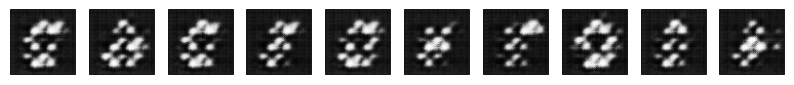

Epoch [4/30], Step [30/118], d_loss: 0.8381, g_loss: 1.4646, D(x): 0.82, D(G(noise)): 0.46
Epoch [4/30], Step [60/118], d_loss: 2.1227, g_loss: 1.8676, D(x): 0.92, D(G(noise)): 0.86
Epoch [4/30], Step [90/118], d_loss: 0.8652, g_loss: 0.7624, D(x): 0.49, D(G(noise)): 0.11
Epoch [5/30], Step [30/118], d_loss: 1.2989, g_loss: 1.1844, D(x): 0.33, D(G(noise)): 0.12
Epoch [5/30], Step [60/118], d_loss: 0.8379, g_loss: 1.2033, D(x): 0.65, D(G(noise)): 0.32
Epoch [5/30], Step [90/118], d_loss: 0.9998, g_loss: 1.1577, D(x): 0.66, D(G(noise)): 0.43
Epoch [6/30], Step [30/118], d_loss: 1.0087, g_loss: 1.0344, D(x): 0.62, D(G(noise)): 0.40
Epoch [6/30], Step [60/118], d_loss: 1.3092, g_loss: 0.9167, D(x): 0.35, D(G(noise)): 0.21
Epoch [6/30], Step [90/118], d_loss: 1.9974, g_loss: 0.5688, D(x): 0.16, D(G(noise)): 0.11


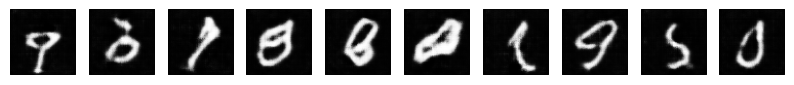

Epoch [7/30], Step [30/118], d_loss: 0.9866, g_loss: 0.9358, D(x): 0.60, D(G(noise)): 0.37
Epoch [7/30], Step [60/118], d_loss: 0.9765, g_loss: 0.6167, D(x): 0.54, D(G(noise)): 0.29
Epoch [7/30], Step [90/118], d_loss: 1.0213, g_loss: 1.3693, D(x): 0.71, D(G(noise)): 0.48
Epoch [8/30], Step [30/118], d_loss: 0.9237, g_loss: 0.8289, D(x): 0.60, D(G(noise)): 0.32
Epoch [8/30], Step [60/118], d_loss: 0.9529, g_loss: 1.0851, D(x): 0.61, D(G(noise)): 0.36
Epoch [8/30], Step [90/118], d_loss: 0.9580, g_loss: 1.4564, D(x): 0.71, D(G(noise)): 0.45
Epoch [9/30], Step [30/118], d_loss: 1.1693, g_loss: 0.8465, D(x): 0.40, D(G(noise)): 0.18
Epoch [9/30], Step [60/118], d_loss: 0.9226, g_loss: 0.9594, D(x): 0.59, D(G(noise)): 0.31
Epoch [9/30], Step [90/118], d_loss: 0.9368, g_loss: 1.8454, D(x): 0.82, D(G(noise)): 0.51


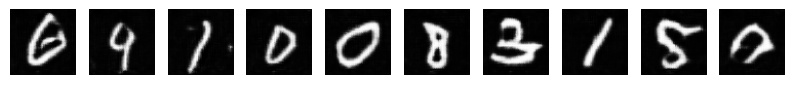

Epoch [10/30], Step [30/118], d_loss: 0.9060, g_loss: 1.5931, D(x): 0.65, D(G(noise)): 0.36
Epoch [10/30], Step [60/118], d_loss: 1.0186, g_loss: 1.2395, D(x): 0.62, D(G(noise)): 0.39
Epoch [10/30], Step [90/118], d_loss: 1.4404, g_loss: 2.8189, D(x): 0.91, D(G(noise)): 0.73
Epoch [11/30], Step [30/118], d_loss: 1.1260, g_loss: 1.9000, D(x): 0.86, D(G(noise)): 0.61
Epoch [11/30], Step [60/118], d_loss: 0.9884, g_loss: 0.8736, D(x): 0.46, D(G(noise)): 0.15
Epoch [11/30], Step [90/118], d_loss: 1.5079, g_loss: 3.4314, D(x): 0.93, D(G(noise)): 0.75
Epoch [12/30], Step [30/118], d_loss: 0.8611, g_loss: 1.5395, D(x): 0.70, D(G(noise)): 0.39
Epoch [12/30], Step [60/118], d_loss: 0.8893, g_loss: 1.9641, D(x): 0.76, D(G(noise)): 0.44
Epoch [12/30], Step [90/118], d_loss: 0.7922, g_loss: 2.0196, D(x): 0.75, D(G(noise)): 0.39


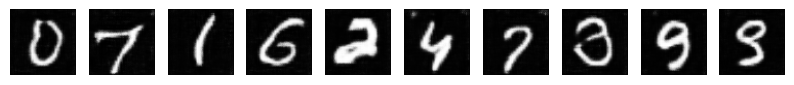

Epoch [13/30], Step [30/118], d_loss: 0.7823, g_loss: 1.5575, D(x): 0.69, D(G(noise)): 0.32
Epoch [13/30], Step [60/118], d_loss: 1.0376, g_loss: 1.1010, D(x): 0.51, D(G(noise)): 0.28
Epoch [13/30], Step [90/118], d_loss: 0.9413, g_loss: 0.8785, D(x): 0.54, D(G(noise)): 0.25
Epoch [14/30], Step [30/118], d_loss: 0.8650, g_loss: 1.5747, D(x): 0.75, D(G(noise)): 0.42
Epoch [14/30], Step [60/118], d_loss: 0.9385, g_loss: 1.4969, D(x): 0.66, D(G(noise)): 0.39
Epoch [14/30], Step [90/118], d_loss: 1.0917, g_loss: 3.0723, D(x): 0.85, D(G(noise)): 0.59
Epoch [15/30], Step [30/118], d_loss: 1.2048, g_loss: 0.9535, D(x): 0.45, D(G(noise)): 0.32
Epoch [15/30], Step [60/118], d_loss: 0.9910, g_loss: 0.1497, D(x): 0.45, D(G(noise)): 0.13
Epoch [15/30], Step [90/118], d_loss: 1.0722, g_loss: 1.3433, D(x): 0.51, D(G(noise)): 0.30


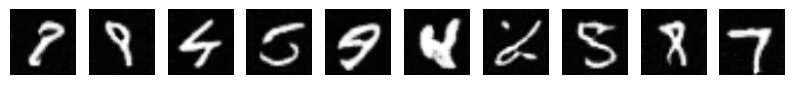

Epoch [16/30], Step [30/118], d_loss: 0.8907, g_loss: 1.3048, D(x): 0.67, D(G(noise)): 0.38
Epoch [16/30], Step [60/118], d_loss: 1.0148, g_loss: 1.4196, D(x): 0.61, D(G(noise)): 0.38
Epoch [16/30], Step [90/118], d_loss: 0.9279, g_loss: 1.1091, D(x): 0.68, D(G(noise)): 0.40
Epoch [17/30], Step [30/118], d_loss: 1.1677, g_loss: 2.7863, D(x): 0.84, D(G(noise)): 0.62
Epoch [17/30], Step [60/118], d_loss: 0.9977, g_loss: 2.7133, D(x): 0.88, D(G(noise)): 0.57
Epoch [17/30], Step [90/118], d_loss: 1.3573, g_loss: 0.7597, D(x): 0.31, D(G(noise)): 0.13
Epoch [18/30], Step [30/118], d_loss: 0.9133, g_loss: 1.1148, D(x): 0.54, D(G(noise)): 0.24
Epoch [18/30], Step [60/118], d_loss: 0.9906, g_loss: 1.0795, D(x): 0.78, D(G(noise)): 0.50
Epoch [18/30], Step [90/118], d_loss: 0.9669, g_loss: 1.2502, D(x): 0.66, D(G(noise)): 0.41


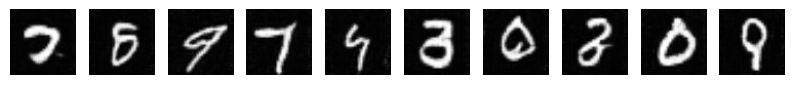

Epoch [19/30], Step [30/118], d_loss: 0.8251, g_loss: 1.4737, D(x): 0.67, D(G(noise)): 0.33
Epoch [19/30], Step [60/118], d_loss: 0.9319, g_loss: 1.5106, D(x): 0.71, D(G(noise)): 0.43
Epoch [19/30], Step [90/118], d_loss: 1.3870, g_loss: 0.4595, D(x): 0.29, D(G(noise)): 0.09
Epoch [20/30], Step [30/118], d_loss: 0.7635, g_loss: 1.8753, D(x): 0.77, D(G(noise)): 0.38
Epoch [20/30], Step [60/118], d_loss: 1.0940, g_loss: 0.9721, D(x): 0.50, D(G(noise)): 0.31
Epoch [20/30], Step [90/118], d_loss: 0.9961, g_loss: 1.9158, D(x): 0.80, D(G(noise)): 0.52
Epoch [21/30], Step [30/118], d_loss: 0.8847, g_loss: 0.9310, D(x): 0.66, D(G(noise)): 0.36
Epoch [21/30], Step [60/118], d_loss: 1.0963, g_loss: 1.0054, D(x): 0.55, D(G(noise)): 0.37
Epoch [21/30], Step [90/118], d_loss: 1.0800, g_loss: 1.5363, D(x): 0.63, D(G(noise)): 0.44


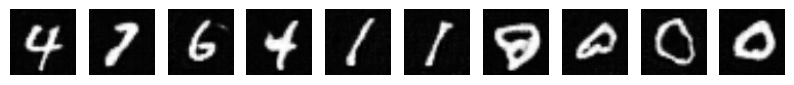

Epoch [22/30], Step [30/118], d_loss: 1.0760, g_loss: 2.1420, D(x): 0.87, D(G(noise)): 0.60
Epoch [22/30], Step [60/118], d_loss: 1.0514, g_loss: 1.5811, D(x): 0.73, D(G(noise)): 0.51
Epoch [22/30], Step [90/118], d_loss: 1.0874, g_loss: 1.6746, D(x): 0.87, D(G(noise)): 0.60
Epoch [23/30], Step [30/118], d_loss: 1.0608, g_loss: 1.0313, D(x): 0.51, D(G(noise)): 0.30
Epoch [23/30], Step [60/118], d_loss: 0.8925, g_loss: 1.3725, D(x): 0.65, D(G(noise)): 0.35
Epoch [23/30], Step [90/118], d_loss: 0.9084, g_loss: 1.2249, D(x): 0.60, D(G(noise)): 0.31
Epoch [24/30], Step [30/118], d_loss: 0.9425, g_loss: 1.6341, D(x): 0.72, D(G(noise)): 0.44
Epoch [24/30], Step [60/118], d_loss: 1.0854, g_loss: 0.6144, D(x): 0.40, D(G(noise)): 0.13
Epoch [24/30], Step [90/118], d_loss: 1.0393, g_loss: 0.6387, D(x): 0.44, D(G(noise)): 0.15


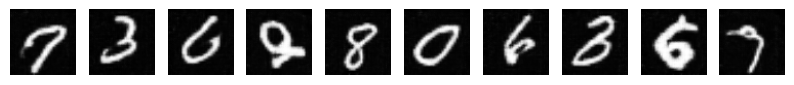

Epoch [25/30], Step [30/118], d_loss: 0.8523, g_loss: 2.7402, D(x): 0.82, D(G(noise)): 0.47
Epoch [25/30], Step [60/118], d_loss: 0.8596, g_loss: 1.7789, D(x): 0.75, D(G(noise)): 0.42
Epoch [25/30], Step [90/118], d_loss: 0.9832, g_loss: 0.8306, D(x): 0.51, D(G(noise)): 0.25
Epoch [26/30], Step [30/118], d_loss: 0.8903, g_loss: 1.5746, D(x): 0.68, D(G(noise)): 0.38
Epoch [26/30], Step [60/118], d_loss: 1.1072, g_loss: 1.4853, D(x): 0.57, D(G(noise)): 0.40
Epoch [26/30], Step [90/118], d_loss: 1.0818, g_loss: 1.2966, D(x): 0.62, D(G(noise)): 0.44
Epoch [27/30], Step [30/118], d_loss: 1.0461, g_loss: 0.9505, D(x): 0.47, D(G(noise)): 0.21
Epoch [27/30], Step [60/118], d_loss: 1.0696, g_loss: 1.2959, D(x): 0.71, D(G(noise)): 0.50
Epoch [27/30], Step [90/118], d_loss: 0.9502, g_loss: 1.6106, D(x): 0.70, D(G(noise)): 0.43


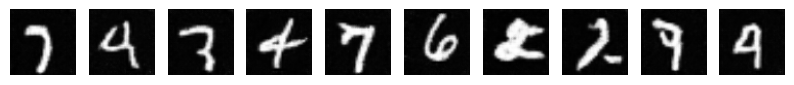

Epoch [28/30], Step [30/118], d_loss: 1.0009, g_loss: 1.2446, D(x): 0.53, D(G(noise)): 0.28
Epoch [28/30], Step [60/118], d_loss: 1.0616, g_loss: 3.5466, D(x): 0.89, D(G(noise)): 0.59
Epoch [28/30], Step [90/118], d_loss: 0.9185, g_loss: 1.4975, D(x): 0.80, D(G(noise)): 0.49
Epoch [29/30], Step [30/118], d_loss: 1.2777, g_loss: 1.5213, D(x): 0.80, D(G(noise)): 0.63
Epoch [29/30], Step [60/118], d_loss: 0.9520, g_loss: 3.0354, D(x): 0.86, D(G(noise)): 0.54
Epoch [29/30], Step [90/118], d_loss: 0.8488, g_loss: 0.8108, D(x): 0.54, D(G(noise)): 0.18
Epoch [30/30], Step [30/118], d_loss: 1.2643, g_loss: 2.2864, D(x): 0.86, D(G(noise)): 0.66
Epoch [30/30], Step [60/118], d_loss: 0.9078, g_loss: 1.2458, D(x): 0.53, D(G(noise)): 0.22
Epoch [30/30], Step [90/118], d_loss: 0.7333, g_loss: 1.5431, D(x): 0.71, D(G(noise)): 0.31


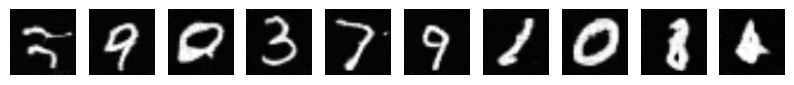

In [11]:
num_epochs = 15
discriminator_loss, generator_loss = [], []  # List to accumulate discriminator and generator losses
real_label = 1.
fake_label = 0.

for epoch in tqdm(range(num_epochs)):
    gen_epoch_loss, dis_epoch_loss = 0.0, 0.0
    for i, (images, _) in enumerate(trainloader):
        batch_size = images.size(0)
        images = images.to(device)
        labels = torch.full((batch_size,), real_label).to(device)

        # Zero gradients for discriminator
        dis_optimizer.zero_grad()

        # Train Discriminator on real images
        outputs = discriminator(images).view(-1)
        dis_real_data_loss = loss_fn(outputs, labels)
        dis_real_data_loss.backward()
        real_score = outputs

        # Train Discriminator on fake images
        noise = torch.randn(batch_size, latent_dim, 1, 1).to(device)
        fake_images = generator(noise)
        labels.fill_(fake_label)
        outputs = discriminator(fake_images.detach()).view(-1)
        dis_fake_data_loss = loss_fn(outputs, labels)
        dis_fake_data_loss.backward()
        fake_score = outputs

        # Update Discriminator
        dis_loss = dis_real_data_loss + dis_fake_data_loss
        dis_optimizer.step()

        # Zero gradients for generator
        gen_optimizer.zero_grad()

        # Train Generator
        labels.fill_(real_label)
        outputs = discriminator(fake_images).view(-1)
        gen_loss = loss_fn(outputs, labels)
        gen_loss.backward()

        # Update Generator
        gen_optimizer.step()

        dis_epoch_loss += dis_loss.item()
        gen_epoch_loss += gen_loss.item()

        if (i+1) % 30 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(trainloader)}], d_loss: {dis_loss.item():.4f}, g_loss: {gen_loss.item():.4f}, D(x): {real_score.mean().item():.2f}, D(G(noise)): {fake_score.mean().item():.2f}')

    generator_loss.append(gen_epoch_loss / len(trainloader))
    discriminator_loss.append(dis_epoch_loss / len(trainloader))

    # Visualize the intermediate results
    if (epoch+1) % 3 == 0:
        with torch.inference_mode():
            fake_images = generator(torch.randn(10, latent_dim, 1, 1).to(device)).detach().cpu()
        fake_images = fake_images.numpy().reshape(10, 1, 64, 64)
        fig, ax = plt.subplots(1, 10, figsize=(10, 1))
        for j in range(10):
            ax[j].imshow(fake_images[j, 0], cmap='gray')
            ax[j].axis('off')
        plt.show()

## 6. Plot Loss Curves

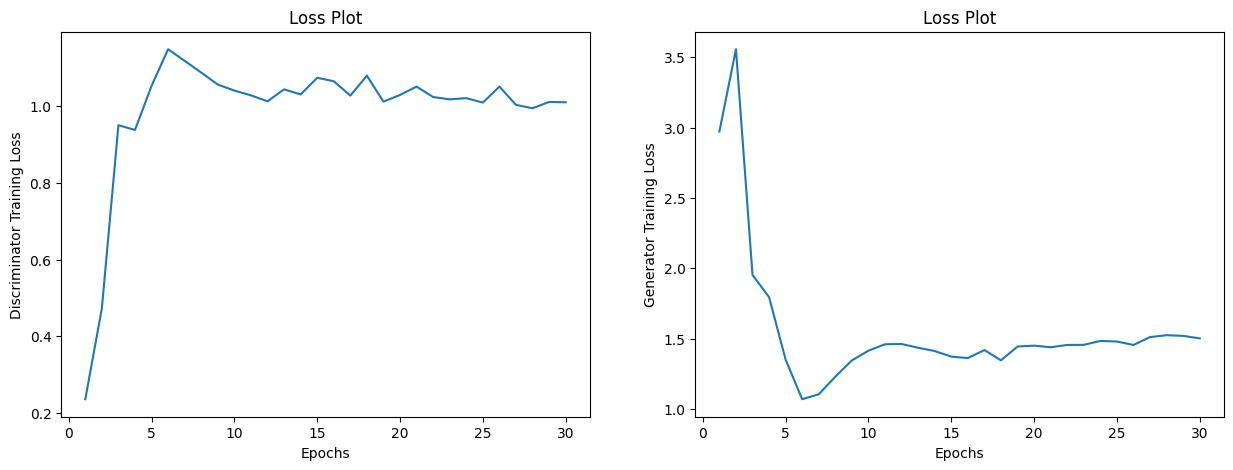

In [12]:
plt.figure(figsize=(15, 5))

# Subplot for discriminator and generator loss
plt.subplot(1, 2, 1)
plt.title("Loss Plot")
train_num_epoch = [i + 1 for i in range(len(discriminator_loss))]
plt.plot(train_num_epoch, discriminator_loss)
plt.xlabel("Epochs")
plt.ylabel("Discriminator Training Loss")

plt.subplot(1, 2, 2)
plt.title("Loss Plot")
train_num_epoch = [i + 1 for i in range(len(discriminator_loss))]
plt.plot(train_num_epoch, generator_loss)
plt.xlabel("Epochs")
plt.ylabel("Generator Training Loss")
plt.show()

## 7. Saving Models

In [13]:
from pathlib import Path

# Create model directory
model_path = Path('models')
model_path.mkdir(parents=True, exist_ok=True)

# Create model save path
GEN_MODEL_NAME, DIS_MODEL_NAME = "generator.pt", "discriminator.pt"
gen_model_save_path = model_path / GEN_MODEL_NAME
dis_model_save_path = model_path / DIS_MODEL_NAME

# Save the model state dict
print(f"Saving model to: {gen_model_save_path}")
print(f"Saving model to: {dis_model_save_path}")
torch.save(obj = generator.state_dict(),            # only saving the state_dict() only saves the learned parameters
           f = gen_model_save_path)
torch.save(obj = discriminator.state_dict(),        # only saving the state_dict() only saves the learned parameters
           f = dis_model_save_path)
print('Saved Successfully')

Saving model to: models/generator.pt
Saving model to: models/discriminator.pt
Saved Successfully


## 8. Generate Image by Inferencing on Trained GAN

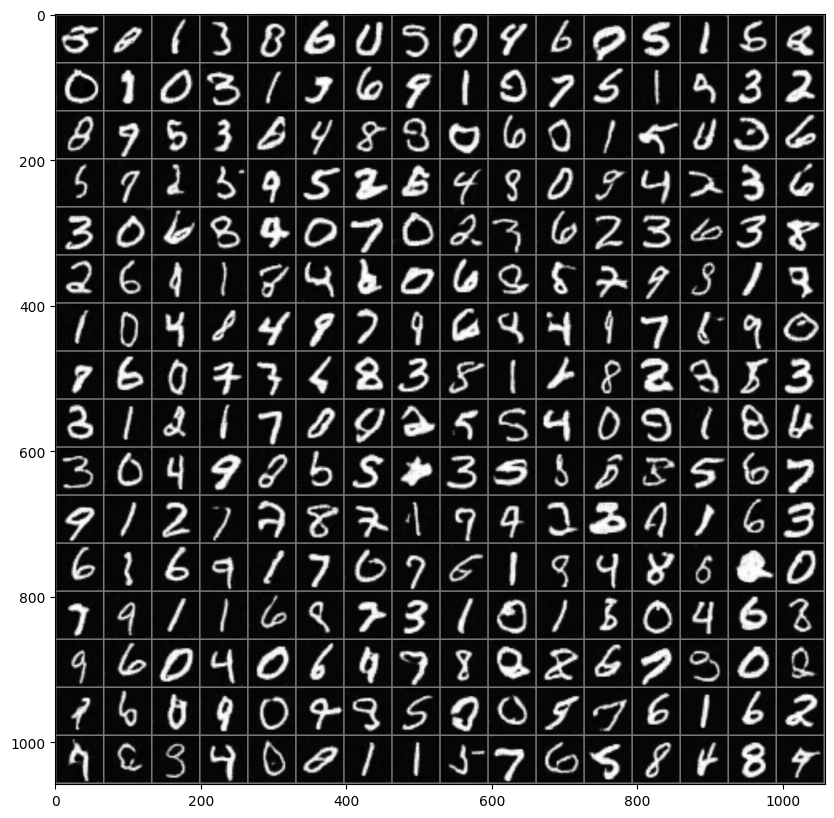

In [28]:
# Generator model
generator = Generator(input_size=100, hidden_size=128, output_size=1)

#  Load the model to cpu and set tot eval mode
generator.load_state_dict(torch.load(f=gen_model_save_path, map_location='cpu'))
generator.eval()

# Generate latent vectors
num_samples = 256
input_noise = torch.randn(num_samples, latent_dim, 1, 1).to('cpu')

# Generate image using latent vectors
generated_samples = generator(input_noise)
generated_samples_np = generated_samples.detach().cpu().numpy()

# Visualize the generated samples
plt.figure(figsize=(10, 10))
show_grid(generated_samples, n_row=16)

## Resources:

- [Video Explanation on GAN](https://www.youtube.com/watch?v=TpMIssRdhco)
- [Paper on DCGANs](https://arxiv.org/pdf/1511.06434)